In [3]:
import requests
import csv
from datetime import datetime

# Define USGS API endpoint
BASE_URL = "https://earthquake.usgs.gov/fdsnws/event/1/query"

# Define parameters for the API request
params = {
    "format": "geojson",
    "starttime": "2020-01-01",
    "endtime": "2025-07-24",
    "minmagnitude": 3.0,
    "limit": 20000,
    "orderby": "time-asc"
}


response = requests.get(BASE_URL, params=params)
data = response.json()


with open("earthquakes.csv", "w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)


    writer.writerow([
        "id", "time", "latitude", "longitude", "depth", "mag",
        "location", "country",  # <-- Normalized fields
        "type", "status", "tsunami", "sig", "net"
    ])


    for feature in data["features"]:
        props = feature["properties"]
        coords = feature["geometry"]["coordinates"]  # [lon, lat, depth]
        place = props.get("place")


        if place and "," in place:
            location_part, country_part = [s.strip() for s in place.rsplit(",", 1)]

            writer.writerow([
                feature.get("id"),
                props.get("time"),
                coords[1],  # latitude
                coords[0],  # longitude
                coords[2],  # depth
                props.get("mag"),
                location_part,
                country_part,
                props.get("type"),
                props.get("status"),
                props.get("tsunami"),
                props.get("sig"),
                props.get("net")
            ])

print("Normalized earthquake data saved to 'earthquakes.csv'")


KeyboardInterrupt: 

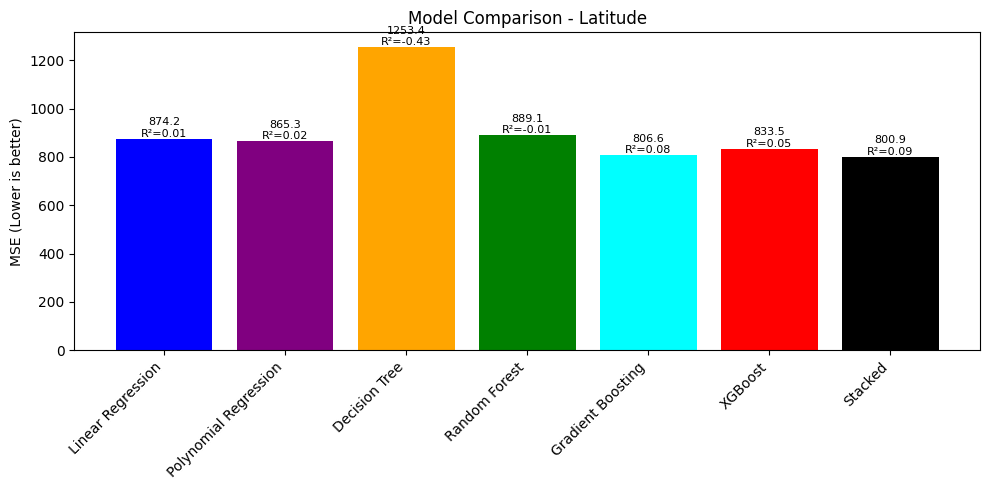

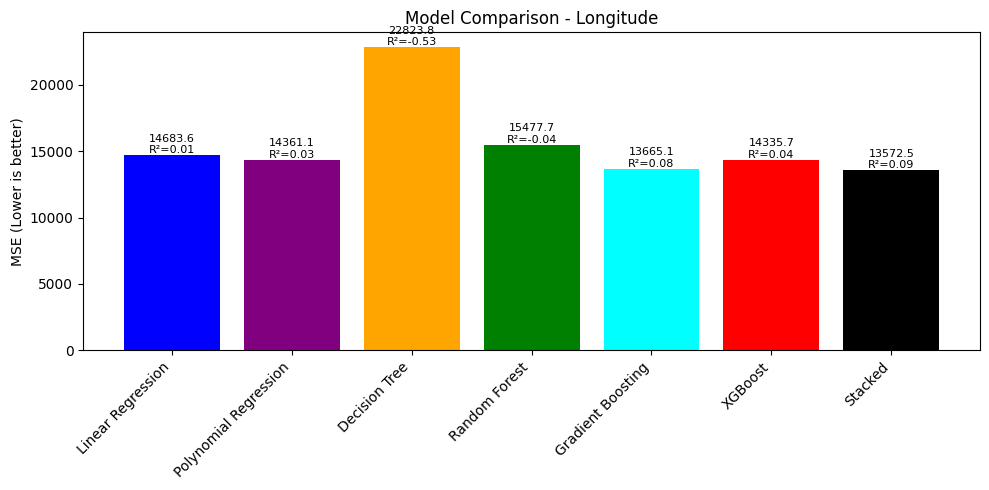

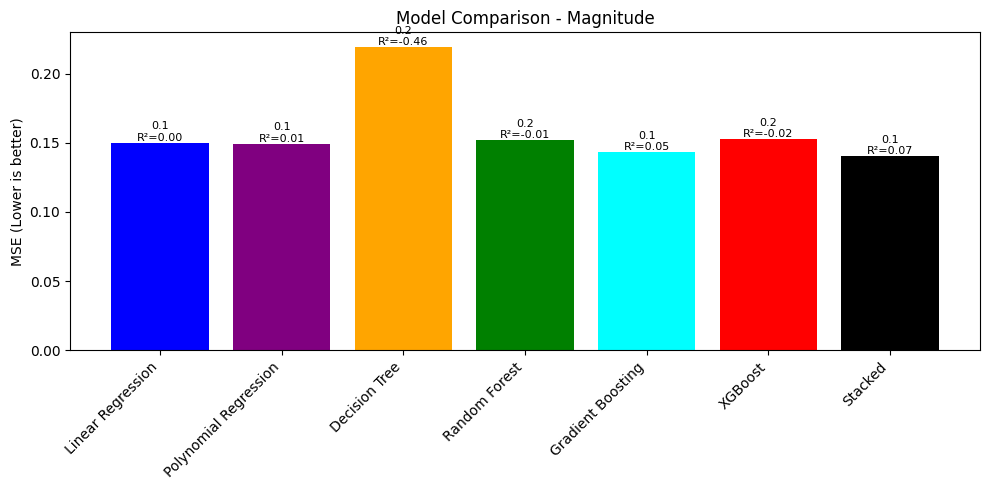

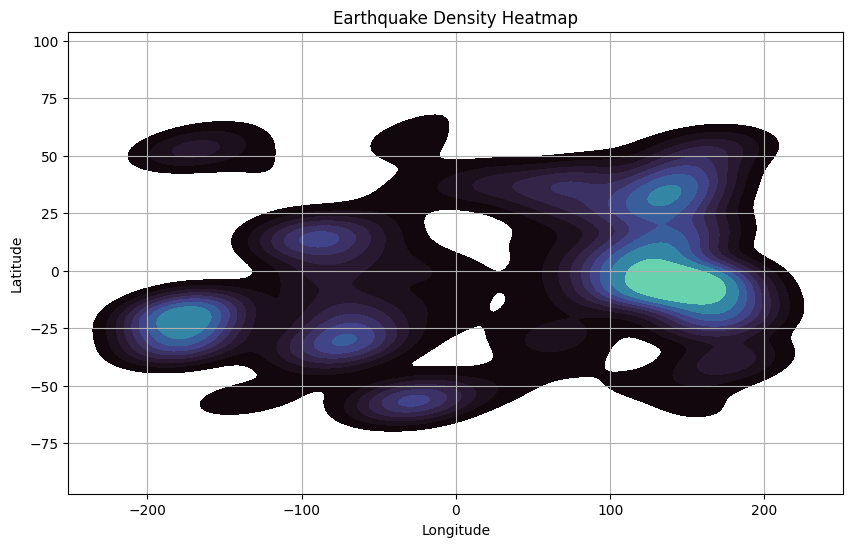

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load and clean data
df = pd.read_csv("earthquakes.csv")  # Use fixed ID version

# Drop rows with essential NaNs
df = df.dropna(subset=["latitude", "longitude", "mag", "depth", "time"])

# Convert time to datetime then Unix timestamp (seconds)
df["time"] = pd.to_datetime(df["time"], errors="coerce")
df = df.dropna(subset=["time"])
df["timestamp"] = df["time"].astype("int64") // 10**9  # seconds

# Drop non-numeric fields
df = df.drop(columns=["place", "time", "type", "net", "id"], errors='ignore')

# Features & Targets
X = df[["depth", "timestamp"]]
y_lat = df["latitude"]
y_long = df["longitude"]
y_mag = df["mag"]

# Split data
X_train, X_test, y_lat_train, y_lat_test = train_test_split(X, y_lat, test_size=0.2, random_state=42)
_, _, y_long_train, y_long_test = train_test_split(X, y_long, test_size=0.2, random_state=42)
_, _, y_mag_train, y_mag_test = train_test_split(X, y_mag, test_size=0.2, random_state=42)

# Models
from sklearn.pipeline import make_pipeline

models = {
    "Linear Regression": LinearRegression(),
    "Polynomial Regression": make_pipeline(PolynomialFeatures(degree=2), LinearRegression()),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, objective="reg:squarederror"),
}

# Evaluate and store results
def evaluate_models(y_train, y_test, X_train, X_test):
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        mse = mean_squared_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        results[name] = {
            "mse": mse,
            "r2": r2
        }
    return results

# Add stacking ensemble
base_models = [(name, model) for name, model in models.items() if name != "Polynomial Regression"]
stack_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression(), passthrough=True)

def evaluate_stack(y_train, y_test):
    stack_model.fit(X_train, y_train)
    pred = stack_model.predict(X_test)
    return {
        "mse": mean_squared_error(y_test, pred),
        "r2": r2_score(y_test, pred)
    }

# Run evaluation
mse_lat = evaluate_models(y_lat_train, y_lat_test, X_train, X_test)
mse_lat["Stacked"] = evaluate_stack(y_lat_train, y_lat_test)

mse_long = evaluate_models(y_long_train, y_long_test, X_train, X_test)
mse_long["Stacked"] = evaluate_stack(y_long_train, y_long_test)

mse_mag = evaluate_models(y_mag_train, y_mag_test, X_train, X_test)
mse_mag["Stacked"] = evaluate_stack(y_mag_train, y_mag_test)

# Plotting
def plot_mse(mse_dict, title, color_map):
    plt.figure(figsize=(10, 5))
    models_list = list(mse_dict.keys())
    values = [mse_dict[model]["mse"] for model in models_list]
    r2_values = [mse_dict[model]["r2"] for model in models_list]
    colors = [color_map.get(model, "#333333") for model in models_list]

    bars = plt.bar(models_list, values, color=colors)
    plt.title(f"Model Comparison - {title}")
    plt.ylabel("MSE (Lower is better)")
    plt.xticks(rotation=45, ha="right")

    for bar, mse_val, r2_val in zip(bars, values, r2_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{mse_val:.1f}\nR²={r2_val:.2f}",
                 ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

# Color map
color_map = {
    "Linear Regression": "blue",
    "Polynomial Regression": "purple",
    "Decision Tree": "orange",
    "Random Forest": "green",
    "Gradient Boosting": "cyan",
    "XGBoost": "red",
    "Stacked": "black",
}

# Plot all
plot_mse(mse_lat, "Latitude", color_map)
plot_mse(mse_long, "Longitude", color_map)
plot_mse(mse_mag, "Magnitude", color_map)

# Optional: Heatmap of earthquake frequency by lat/lon (exploratory)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x="longitude", y="latitude", fill=True, cmap="mako", bw_adjust=1)
plt.title("Earthquake Density Heatmap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


In [8]:
df = pd.read_csv("earthquakes.csv")

NameError: name 'pd' is not defined

In [26]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

# Load your dataset
df = pd.read_csv("earthquakes.csv")

# Drop non-numeric and target-related columns from features
X = df.drop(columns=["latitude", "longitude", "mag", "place", "id"], errors='ignore')

# Identify categorical and numerical columns
categorical_features = ['type', 'status', 'net']
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (like 'time')
)

# Targets
y_lat = df["latitude"]
y_long = df["longitude"]
y_mag = df["mag"]

# Train/test split - apply split before preprocessing to avoid data leakage
X_train, X_test, y_lat_train, y_lat_test = train_test_split(X, y_lat, test_size=0.2, random_state=42)
_, _, y_long_train, y_long_test = train_test_split(X, y_long, test_size=0.2, random_state=42)
_, _, y_mag_train, y_mag_test = train_test_split(X, y_mag, test_size=0.2, random_state=42)

# Apply preprocessing to training and testing data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


# Base models
base_models = [
    ('xgb', XGBRegressor(n_estimators=100, random_state=42, enable_categorical=True)),
    ('ridge', Ridge()),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
]

# Final model
final_estimator = LinearRegression()

# Stacking Regressors
stack_lat = StackingRegressor(estimators=base_models, final_estimator=final_estimator)
stack_long = StackingRegressor(estimators=base_models, final_estimator=final_estimator)
stack_mag = StackingRegressor(estimators=base_models, final_estimator=final_estimator)

# Train models
stack_lat.fit(X_train_processed, y_lat_train)
stack_long.fit(X_train_processed, y_long_train)
stack_mag.fit(X_train_processed, y_mag_train)

# Predict
lat_pred = stack_lat.predict(X_test_processed)
long_pred = stack_long.predict(X_test_processed)
mag_pred = stack_mag.predict(X_test_processed)

# Evaluate
def evaluate(true, pred, label):
    mse = mean_squared_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"{label} - MSE: {mse:.4f}, R2: {r2:.4f}")
    return mse, r2

mse_lat, r2_lat = evaluate(y_lat_test, lat_pred, "Latitude")
mse_long, r2_long = evaluate(y_long_test, long_pred, "Longitude")
mse_mag, r2_mag = evaluate(y_mag_test, mag_pred, "Magnitude")

# Visualize MSEs
labels = ['Latitude', 'Longitude', 'Magnitude']
mses = [mse_lat, mse_long, mse_mag]

plt.bar(labels, mses, color='teal')
plt.title('MSE of Stacked Models')
plt.ylabel('Mean Squared Error')
plt.show()

ValueError: could not convert string to float: '35 km SSW of San Pedro de Atacama'

In [36]:
import matplotlib.pyplot as plt
import pandas as pd


df = pd.read_csv("earthquakes.csv")
df.head(50)

,id,time,latitude,longitude,depth,mag,location,country,type,status,tsunami,sig,net
0,us70006vkq,1578377119759,2.3481,96.3575,17.00,6.3,14 km S of Sinabang,Indonesia,earthquake,reviewed,0,619,us
1,pr2020007007,1578385467370,17.9578,-66.8113,6.00,6.4,4 km SSE of Indios,Puerto Rico,earthquake,reviewed,1,1820,pr
2,us70006vvr,1578424295665,-5.2046,151.2659,117.00,6.0,130 km ENE of Kimbe,Papua New Guinea,earthquake,reviewed,0,554,us
3,us70006wuf,1578559088278,62.3580,171.0611,10.00,6.4,Chukotskiy Avtonomnyy Okrug,Russia,earthquake,reviewed,0,630,us
4,us60007a3h,1579365494301,-2.8405,139.3363,44.00,6.0,146 km W of Abepura,Indonesia,earthquake,reviewed,0,555,us
5,us60007anp,1579440476630,39.8353,77.1084,5.55,6.0,104 km ENE of Kashgar,China,earthquake,reviewed,0,1006,us
6,us60007arp,1579453100002,-0.1042,123.8025,121.72,6.1,108 km SE of Gorontalo,Indonesia,earthquake,reviewed,0,574,us
7,us60007djn,1579758782618,51.9836,-177.8550,10.00,6.2,84 km W of Adak,Alaska,earthquake,reviewed,0,595,us
8,us60007ewc,1579888514147,38.4312,39.0609,10.00,6.7,13 km N of Do?anyol,Turkey,earthquake,reviewed,0,1169,us
9,us60007g8m,1580020315398,51.1338,-179.8892,17.00,6.1,240 km WSW of Adak,Alaska,earthquake,reviewed,1,573,us


/tmp/ipython-input-35-4253359808.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_countries, x="count", y="country", palette="viridis")


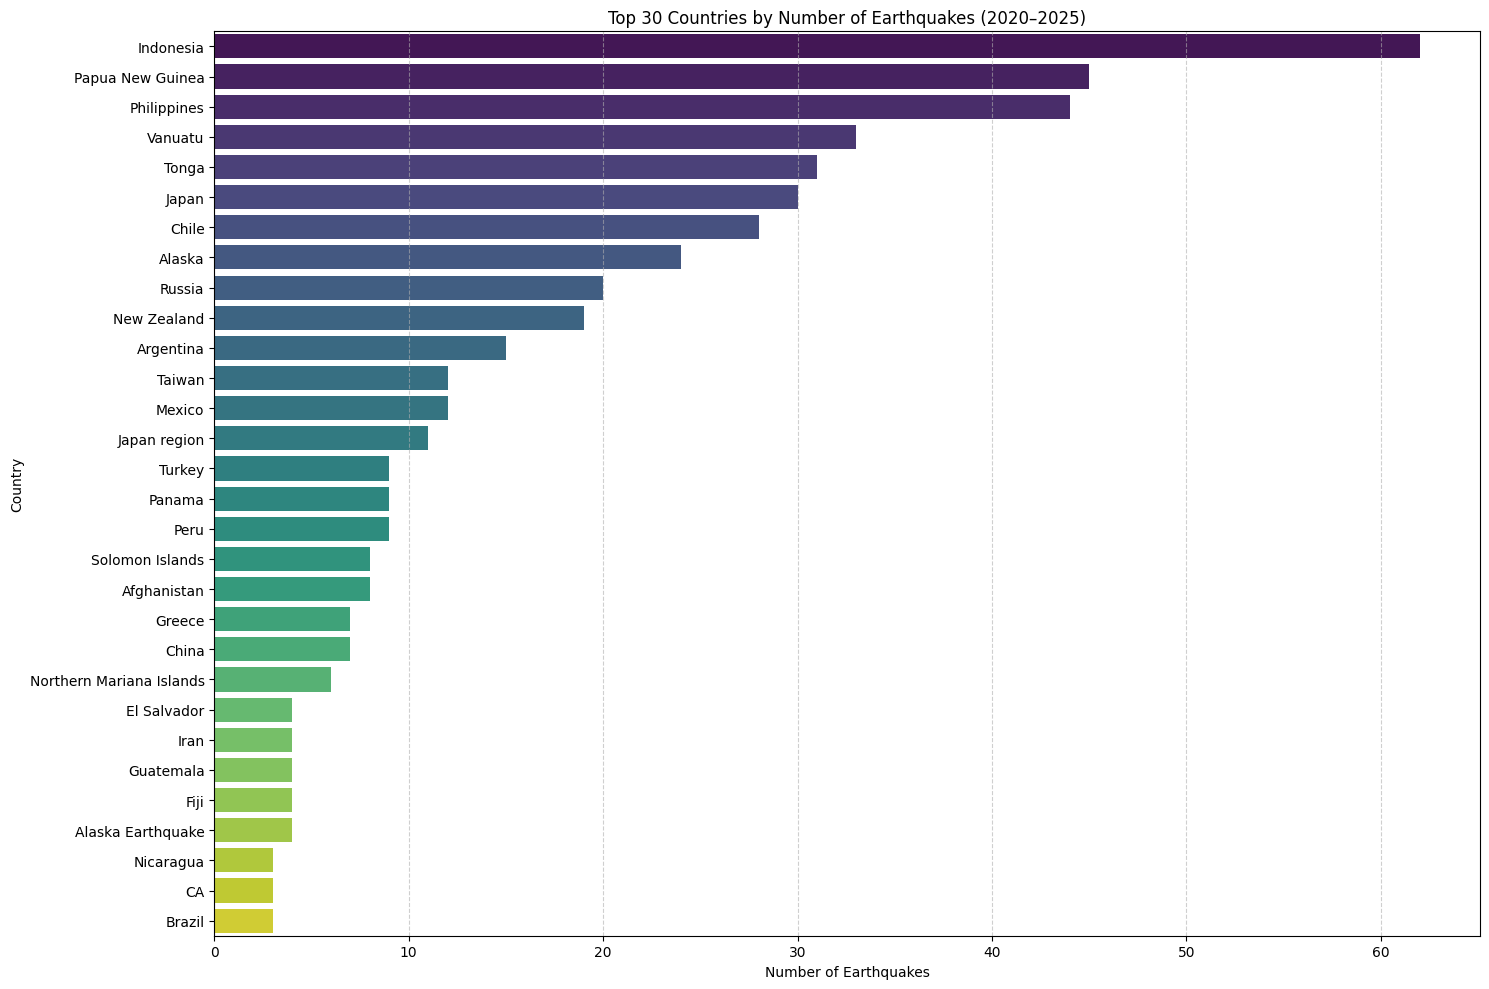

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the normalized earthquake dataset
df = pd.read_csv("earthquakes.csv")

# Drop rows where country is missing (optional, but safe)
df = df.dropna(subset=["country"])

# Count earthquakes per country
country_counts = df["country"].value_counts().reset_index()
country_counts.columns = ["country", "count"]

# Optionally limit to top N countries
top_n = 30
top_countries = country_counts.head(top_n)

# Plot
plt.figure(figsize=(15, 10))
sns.barplot(data=top_countries, x="count", y="country", palette="viridis")
plt.title(f"Top {top_n} Countries by Number of Earthquakes (2020–2025)")
plt.xlabel("Number of Earthquakes")
plt.ylabel("Country")
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.show()


In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from datetime import datetime, timedelta


df = pd.read_csv("/content/earthquakes.csv")
df["time"] = pd.to_datetime(df["time"])
df["timestamp"] = df["time"].astype(np.int64) // 10**9  # Convert to seconds
df["year"] = df["time"].dt.year


encoder = LabelEncoder()
df["country_encoded"] = encoder.fit_transform(df["country"])


X = df[["timestamp"]]
y_mag = df["mag"]
y_country = df["country_encoded"]
y_year = df["year"]

# Train models
mag_model = RandomForestRegressor(n_estimators=100, random_state=42)
mag_model.fit(X, y_mag)

country_model = RandomForestRegressor(n_estimators=100, random_state=42)
country_model.fit(X, y_country)

year_model = RandomForestRegressor(n_estimators=100, random_state=42)
year_model.fit(X, y_year)

# Predict next 5 events
base_timestamp = df["timestamp"].max()
interval = 60 * 60 * 24 * 90  # 90 days in seconds

print("🔮 Predicted Major Earthquakes:\n")
for i in range(1):
    future_timestamp = base_timestamp + interval * (i + 1)
    input_features = pd.DataFrame([[future_timestamp]], columns=["timestamp"])

    predicted_mag = mag_model.predict(input_features)[0]
    predicted_country_encoded = int(country_model.predict(input_features)[0].round())
    predicted_country = encoder.inverse_transform([predicted_country_encoded])[0]
    predicted_year = int(max(year_model.predict(input_features)[0].round(), datetime.now().year + 1))

    print(f"🔮 Predicted Earthquake #{i + 1}")
    print(f"📍 Country: {predicted_country}")
    print(f"📅 Year: {predicted_year}")
    print(f"💥 Magnitude: {round(predicted_mag, 2)}\n")


🔮 Predicted Major Earthquakes:

🔮 Predicted Earthquake #1
📍 Country: Iceland
📅 Year: 2026
💥 Magnitude: 6.23



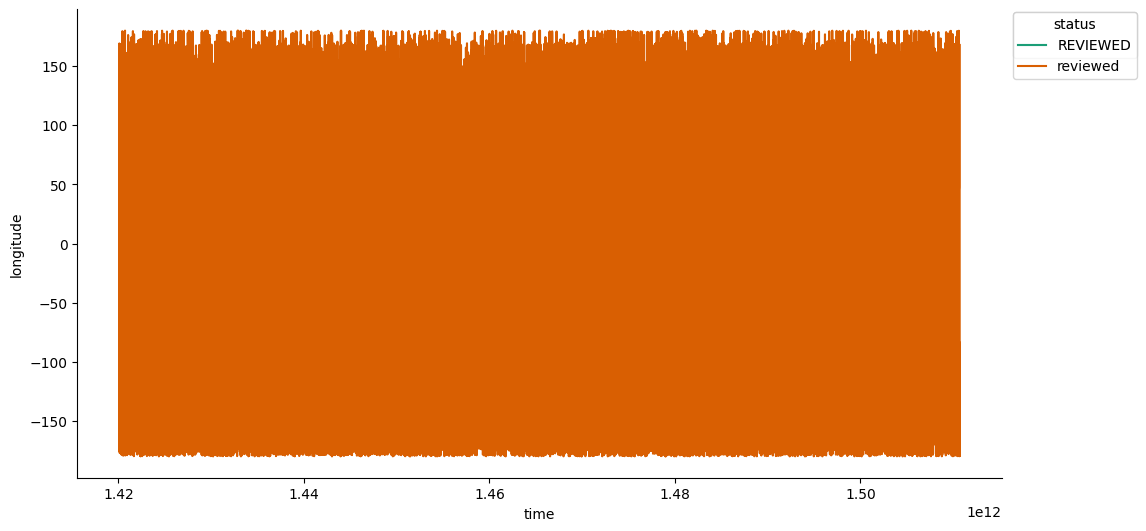

In [11]:
# @title time vs longitude

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time']
  ys = series['longitude']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('status')):
  _plot_series(series, series_name, i)
  fig.legend(title='status', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('longitude')